In [1]:
!pip install selenium webdriver-manager beautifulsoup4 pdfplumber pandas matplotlib 

  Using cached selenium-4.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached webdriver_manager-4.0.2-py2.py3-none-any.whl.metadata (12 kB)
  Using cached trio-0.28.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.11.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
Using cached selenium-4.28.1-py3-none-any.whl (9.5 MB)
Using cached webdriver_manager-4.0.2-py2.py3-none-any.whl (27 kB)
   ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.6 MB ? eta -:--:--
   ----- ---------------------------------

In [5]:
import re
import os
import time

import pdfplumber # доставать из pdf данные

import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)


from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup 

# Сделать датасет с данными по годам о выручке netflix
1. Скачать со страницы netflix финансовые отчеты в `pdf`
2. Получить с `pdf` данные для таблиц
3. Преобразовать в таблицу и сохранить датасет

In [3]:
service = webdriver.ChromeService(executable_path='C:\Program Files (x86)\Google\Chrome\Application\chrome.exe') 
                                  

In [16]:
options = webdriver.ChromeOptions()
options.add_experimental_option('prefs', {
            "plugins.always_open_pdf_externally": True #It will not show PDF directly in chrome
})
browser = webdriver.Chrome(options=options)
link = 'https://ir.netflix.net/financials/annual-reports-and-proxies/default.aspx'
browser.get(link)

In [2]:
folder = 'annual_reports/'

### 1. Получить все ссылки ведущие на отчеты и автоматизированно их скачать

Должен быть включен VPN.

In [ ]:
# страница `https://ir.netflix.net/financials/annual-reports-and-proxies/default.aspx` была заранее скачана
with open(f'{folder}Netflix - Financials - Annual Reports & Proxies.html') as fp:
    soup = BeautifulSoup(fp)

In [19]:
tags = soup.find_all('a', {'class':'module_link module-financial_link'})
tags[0]

<a class="module_link module-financial_link" href="https://s22.q4cdn.com/959853165/files/doc_financials/2023/ar/Netflix-10-K-01262024.pdf" id="_ctrl0_ctl63_repeaterYears_ctl01_dataListReports_ctl00_hrefReport" target="_blank">
<span class="module_link-text">2023 Annual Report</span>
<span class="sr-only">PDF Format Download (opens in new window)</span>
<span class="module_file-type">PDF</span>
<span class="module_file-size" id="_ctrl0_ctl63_repeaterYears_ctl01_dataListReports_ctl00_lblFileSize">1.05 MB</span>
</a>

In [20]:
type(tags[0])

bs4.element.Tag

In [21]:
tags[0]['href']

'https://s22.q4cdn.com/959853165/files/doc_financials/2023/ar/Netflix-10-K-01262024.pdf'

In [22]:
len(tags)

47

In [23]:
lst = []
for tag in tags:
    for child in tag.children:
        if 'Annual Report' in child.text:
            print(child.text)
            lst.append(tag['href'])
            
print(len(lst))

2023 Annual Report
2022 Annual Report
2021 Annual Report
2020 Annual Report
2019 Annual Report
2018 Annual Report
2017 Annual Report
2016 Annual Report
2015 Annual Report
2014 Annual Report
2013 Annual Report
2012 Annual Report
2011 Annual Report
2010 Annual Report
2009 Annual Report
2008 Annual Report
2007 Annual Report
2006 Annual Report
2005 Annual Report
2004 Annual Report
2003 Annual Report
2002 Annual Report
22


In [24]:
lst

['https://s22.q4cdn.com/959853165/files/doc_financials/2023/ar/Netflix-10-K-01262024.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/2022/ar/4e32b45c-a99e-4c7d-b988-4eef8377500c.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/2021/q4/da27d24b-9358-4b5c-a424-6da061d91836.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/2020/ar/8f311d9b-787d-45db-a6ea-38335ede9d47.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/2019/ar/2019-10-K.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/annual_reports/2018/Form-10K_Q418_Filed.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/annual_reports/0001065280-18-000069.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/annual_reports/10K_Final.PDF',
 'https://s22.q4cdn.com/959853165/files/doc_financials/annual_reports/2015_Annual_Report.pdf',
 'https://s22.q4cdn.com/959853165/files/doc_financials/annual_reports/SEC-NFLX-1065280-15-6.pdf',
 'https://s22.q4cdn.com/959853165/f

In [26]:
# скачивание pdf файлов
for link in lst:
    browser.get(link)
    

## анализ pdf файлов

1. Необходимо получить данные для таблиц `CONSOLIDATED STATEMENTS OF OPERATIONS`

In [3]:
# из папки Downloads файлы были перемещены в папку с отчетами
reports = [f for f in os.listdir(folder) if f.endswith('pdf')]
print(len(reports))
reports[:2]

22


['0001065280-18-000069.pdf', '10K_Final.pdf']

In [6]:
folder_text = 'annual_reports_parsed/'

In [109]:
for filename in reports:
    with pdfplumber.open(folder + filename) as pdf:
        print(filename, len(pdf.pages))
        for i, page in enumerate(pdf.pages):
            
            # print(page.chars[0])
            tables = page.extract_tables({'vertical_strategy':'text'})
            text = [x['text'] for x in page.extract_text_lines()]
            if 'CONSOLIDATED STATEMENTS OF OPERATIONS' in text:
                print('page', i)
                line = '\n'.join(text)
                with open(folder_text + filename.replace('.pdf', '.txt'), 'w') as file:
                    file.write(line)
                    
            elif 'CONSOLIDATEDSTATEMENTSOFOPERATIONS' in text:
                print('page', i)
                line = '\n'.join(text)
                with open(folder_text + filename.replace('.pdf', '.not_spaced.txt'), 'w') as file:
                    file.write(line)
 

132054ACL.pdf 76
page 47
2002AR-print.pdf 86
2003AR_print.pdf 87
2004AR_print.pdf 95
page 64
2005ar.pdf 96
2009-AR.pdf 88
page 56
2012_10K.pdf 88
page 53
2015_Annual_Report.pdf 80
page 47
2019-10-K.pdf 78
page 42
4e32b45c-a99e-4c7d-b988-4eef8377500c.pdf 89
page 39
8f311d9b-787d-45db-a6ea-38335ede9d47.pdf 95
page 43
AR_10K_final_2007.pdf 83
page 54
da27d24b-9358-4b5c-a424-6da061d91836.pdf 92
page 40
Final_AR_10K.pdf 84
page 52
Form-10K_Q418_Filed.pdf 78
page 42
Netflix-10-K-01262024.pdf 84
page 41
NFLX.pdf 87
page 57
NFLX_10K.pdf 82
page 50
NFLX_AR.pdf 78
page 47
SEC-NFLX-1065280-15-6.pdf 82
page 45


In [7]:
def preprocess_not_spaced(filename):
    print(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # print(lines)
    years = list(re.findall('([0-9]{4})', lines[4]))
    
    print(years)
    i = 5
    lst = ['column ' + lines[4].strip()]
    head = ''
    while i < len(lines):
        line = lines[i].strip()
        # print(line)
        if '..' not in line:
            head = line.replace(',', '').replace('$', '').replace(')', '').replace('(', '').replace('* ', '').replace('*', '').replace('—', '')
        i += 1
        while i < len(lines) and '..' in line:
            line = line.replace(',', '').replace('$', '').replace(')', '').replace('(', '').replace('* ', '').replace('*', '').replace('—', '')
            
            processed = re.sub('\.{2,}', '', line)
            lst += [head + processed]
            i += 1
            line = lines[i].strip()

    return lst

def parse_not_spaced(filename):
    lst = preprocess_not_spaced(filename)
    folder = 'annual_reports_parsed_step2/'
    processed_filename = folder + filename.split('/')[-1]
    with open(processed_filename, 'w') as file:
        for line in lst:
            file.write(line.replace('  ', ' ').replace('  ', ' ') + '\n')

    df = pd.read_csv(processed_filename, sep=' ')
    df = df.set_index('column').T.rename(columns={'Revenues:Subscription':'Revenues'})
    return df

        

<>:21: SyntaxWarning: invalid escape sequence '\.'
<>:21: SyntaxWarning: invalid escape sequence '\.'
C:\Users\maria\AppData\Local\Temp\ipykernel_14184\349822091.py:21: SyntaxWarning: invalid escape sequence '\.'
  processed = re.sub('\.{2,}', '', line)


In [9]:
files_not_spaced = [f for f in os.listdir(folder_text) if 'not_spaced' in f]
files_spaced = [f for f in os.listdir(folder_text) if 'not_spaced' not in f]
print(len(files_not_spaced), len(files_spaced))
files_not_spaced[:2]

11 8


['10K_Final.not_spaced.txt', '132054ACL.not_spaced.txt']

In [10]:
lst = []
print(len(files_not_spaced))
for i in range(len(files_not_spaced)):
    print(i)
    try:
        lst.append(parse_not_spaced(folder_text + files_not_spaced[i]))
    except BaseException as e:
        print(files_not_spaced[i])
        print(e)

11
0
annual_reports_parsed/10K_Final.not_spaced.txt
['2016', '2015', '2014']
1
annual_reports_parsed/132054ACL.not_spaced.txt
['2010', '2009', '2008']
2
annual_reports_parsed/2004AR_print.not_spaced.txt
['2002', '2003', '2004']
3
annual_reports_parsed/2009-AR.not_spaced.txt
['2009', '2008', '2007']
4
annual_reports_parsed/2012_10K.not_spaced.txt
['2012', '2011', '2010']
5
annual_reports_parsed/2015_Annual_Report.not_spaced.txt
['2015', '2014', '2013']
6
annual_reports_parsed/AR_10K_final_2007.not_spaced.txt
['2007', '2006', '2005']
7
annual_reports_parsed/Final_AR_10K.not_spaced.txt
['2008', '2007', '2006']
8
annual_reports_parsed/NFLX.not_spaced.txt
['2004', '2005', '2006']
9
annual_reports_parsed/NFLX_10K.not_spaced.txt
['2011', '2010', '2009']
10
annual_reports_parsed/NFLX_AR.not_spaced.txt
['2013', '2012', '2011']


In [11]:
merged = pd.concat(lst).reset_index().sort_values('index').rename(columns={'index':'year'})
merged

column,year,Revenues,Marketing,Technologyanddevelopment,Generalandadministrative,Operatingincome,Otherincomeexpense:Interestexpense,Otherincomeexpense:Incomebeforeincometaxes,Otherincomeexpense:Provisionforincometaxes,Otherincomeexpense:Netincome,Earningspershare:Basic,Weighted-averagecommonsharesoutstanding:Basic,Subscription,Fulfillmentexpenses,Totalcostofrevenues,Grossprofit,Operatingexpenses:Technologyanddevelopment,Operatingexpenses:Generalandadministrative,Operatingexpenses:GainondisposalofDVDs,Operatingexpenses:Totaloperatingexpenses,Operatingexpenses:Operatingincome,Netincomepershare:Basic,Revenues:Totalrevenues,Costofrevenues:Subscription,Costofrevenues:Totalcostofrevenues,Operatingexpenses:Fulfillment,Operatingexpenses:Marketing,Operatingexpenses:Stock-basedcompensation,Operatingexpenses:Operatingincomeloss,Otherincomeexpense:Interestandotherincome,Otherincomeexpense:Netincomelossbeforeincometaxes,Otherincomeexpense:Netincomeloss,Netincomelosspershare:Basic,items:Fulfillment,items:Marketing,items:Generalandadministrative,items:Totalstock-basedcompensation,GrossProfit,Operatingexpenses:Gainonlegalsettlement,Stock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Stock-basedcompensationincludedinexpenselineitems:Marketing,Stock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Otherincomeexpense:Lossonextinguishmentofdebt,Otherincomeexpense:Interestandotherincomeexpense,Otherincomeexpense:Provisionforbenefitfromincometaxes,Otherincomeexpense:Interestexpenseonleasefinancingobligations,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Amortizationofstock-basedcompensationincludedinexpenselineitems:Marketing,Amortizationofstock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillment,Operatingexpenses:Legalsettlement
6,2002,150818.0,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,28204.0,NaN,NaN,NaN,NaN,NaN,6737.0,NaN,85343.0,NaN,NaN,152806.0,77044.0,78136.0,19366.0,35783.0,8832.0,10673.0,1697.0,20948.0,20948.0,0.74,1055.0,1640.0,3130.0,8832.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2003,270410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47786.0,NaN,NaN,NaN,NaN,NaN,9585.0,NaN,119411.0,NaN,NaN,272243.0,147736.0,148360.0,31274.0,49949.0,10719.0,4472.0,2457.0,6512.0,6512.0,0.14,1349.0,1586.0,3805.0,10719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2004,500611.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51988.0,NaN,NaN,NaN,NaN,NaN,16287.0,NaN,210416.0,NaN,NaN,506228.0,273401.0,276458.0,56609.0,98027.0,16587.0,19354.0,2592.0,21776.0,21595.0,0.42,1702.0,2507.0,5817.0,16587.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2004,500611.0,NaN,NaN,NaN,NaN,NaN,21776.0,NaN,21595.0,NaN,51988.0,273401.0,58311.0,331712.0,168899.0,29467.0,22104.0,2560.0,149545.0,19354.0,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2592.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,2507.0,5817.0,1702.0,NaN
25,2005,682213.0,NaN,NaN,NaN,NaN,NaN,8335.0,NaN,42027.0,NaN,53528.0,393788.0,71987.0,465775.0,216438.0,35388.0,35486.0,1987.0,213449.0,2989.0,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33692.0,NaN,NaN,2565.0,6091.0,1225.0,NaN
20,2005,682213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42027.0,NaN,53528.0,393788.0,71987.0,465775.0,216438.0,35388.0,35486.0,1987.0,213449.0,2989.0,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0,2565.0,6091.0,NaN,5346.0,33692.0,NaN,NaN,NaN,NaN,NaN,NaN
19,2006,996660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49082.0,NaN,62577.0,532621.0,94364.0,626985.0,369675.0,48379.0,36155.0,4797.0,305261.0,64414.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,925.0,2138.0,6025.0,NaN,15904.0,31236.0,NaN,NaN,NaN,NaN,NaN,NaN
23,2006,996660.0,NaN,NaN,NaN,NaN,NaN,79912.0,31073.0,48839.0,NaN,62577.0,532621.0,94364.0,626985.0,369675.0,47831.0,35987.0,4797.0,304457.0,65218.0

In [12]:
first = merged.groupby('year').first()
first

column,Revenues,Marketing,Technologyanddevelopment,Generalandadministrative,Operatingincome,Otherincomeexpense:Interestexpense,Otherincomeexpense:Incomebeforeincometaxes,Otherincomeexpense:Provisionforincometaxes,Otherincomeexpense:Netincome,Earningspershare:Basic,Weighted-averagecommonsharesoutstanding:Basic,Subscription,Fulfillmentexpenses,Totalcostofrevenues,Grossprofit,Operatingexpenses:Technologyanddevelopment,Operatingexpenses:Generalandadministrative,Operatingexpenses:GainondisposalofDVDs,Operatingexpenses:Totaloperatingexpenses,Operatingexpenses:Operatingincome,Netincomepershare:Basic,Revenues:Totalrevenues,Costofrevenues:Subscription,Costofrevenues:Totalcostofrevenues,Operatingexpenses:Fulfillment,Operatingexpenses:Marketing,Operatingexpenses:Stock-basedcompensation,Operatingexpenses:Operatingincomeloss,Otherincomeexpense:Interestandotherincome,Otherincomeexpense:Netincomelossbeforeincometaxes,Otherincomeexpense:Netincomeloss,Netincomelosspershare:Basic,items:Fulfillment,items:Marketing,items:Generalandadministrative,items:Totalstock-basedcompensation,GrossProfit,Operatingexpenses:Gainonlegalsettlement,Stock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Stock-basedcompensationincludedinexpenselineitems:Marketing,Stock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Otherincomeexpense:Lossonextinguishmentofdebt,Otherincomeexpense:Interestandotherincomeexpense,Otherincomeexpense:Provisionforbenefitfromincometaxes,Otherincomeexpense:Interestexpenseonleasefinancingobligations,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Amortizationofstock-basedcompensationincludedinexpenselineitems:Marketing,Amortizationofstock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillment,Operatingexpenses:Legalsettlement
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002,150818.0,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,28204.0,NaN,NaN,NaN,NaN,NaN,6737.0,NaN,85343.0,NaN,NaN,152806.0,77044.0,78136.0,19366.0,35783.0,8832.0,10673.0,1697.0,20948.0,20948.0,0.74,1055.0,1640.0,3130.0,8832.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,270410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47786.0,NaN,NaN,NaN,NaN,NaN,9585.0,NaN,119411.0,NaN,NaN,272243.0,147736.0,148360.0,31274.0,49949.0,10719.0,4472.0,2457.0,6512.0,6512.0,0.14,1349.0,1586.0,3805.0,10719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,500611.0,NaN,NaN,NaN,NaN,NaN,21776.0,NaN,21595.0,NaN,51988.0,273401.0,58311.0,331712.0,168899.0,29467.0,16287.0,2560.0,210416.0,19354.0,0.42,506228.0,273401.0,276458.0,56609.0,98027.0,16587.0,19354.0,2592.0,21776.0,21595.0,0.42,1702.0,2507.0,5817.0,16587.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,2507.0,5817.0,1702.0,NaN
2005,682213.0,NaN,NaN,NaN,NaN,NaN,8335.0,NaN,42027.0,NaN,53528.0,393788.0,71987.0,465775.0,216438.0,35388.0,35486.0,1987.0,213449.0,2989.0,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0,2565.0,6091.0,NaN,5346.0,33692.0,NaN,NaN,2565.0,6091.0,1225.0,NaN
2006,996660.0,NaN,NaN,NaN,NaN,NaN,79912.0,31073.0,49082.0,NaN,62577.0,532621.0,94364.0,626985.0,369675.0,48379.0,36155.0,4797.0,305261.0,64414.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,925.0,2138.0,6025.0,NaN,15904.0,31236.0,1210.0,925.0,2138.0,6025.0,925.0,NaN
2007,1205340.0,NaN,NaN,NaN,NaN,1188.0,110925.0,44317.0,66952.0,NaN,67076.0,664407.0,121761.0,786168.0,419172.0,71395.0,52532.0,7196.0,328011.0,91161.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419172.0,7000.0,427.0,2160.0,5694.0,NaN,20340.0,44549.0,1188.0,427.0,2160.0,5694.0,NaN,NaN
2008,1364661.0,NaN,NaN,NaN,NaN,2458.0,131500.0,48474.0,83026.0,NaN,60961.0,761133.0,149101.0,910234.0,454427.0,89873.0,49662.0,6327.0,332921.0,121506.0,1.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454427.0,7000.0,466.0,1886.0,6022.0,NaN,NaN,NaN,2458.

In [13]:
# проверка, какие столбцы в каких отчетах есть
cols = set(lst[0].columns)
d = {}
for i, df in enumerate(lst):
    cols &= set(df.columns)
    print(i, df.shape)
    for col in set(df.columns) | set(d.keys()):
        if i == 0:
            print(col)
        if col in d and col in df.columns:
            d[col].append(1)
        elif col in d and col not in df.columns:
            d[col].append(0)
        elif col in df.columns and col not in d:
            d[col] = [1]
        else:
            d[col] = [0] * (i + 1)

0 (3, 11)
Earningspershare:Basic
Weighted-averagecommonsharesoutstanding:Basic
Generalandadministrative
Revenues
Marketing
Technologyanddevelopment
Otherincomeexpense:Interestexpense
Operatingincome
Otherincomeexpense:Provisionforincometaxes
Otherincomeexpense:Incomebeforeincometaxes
Otherincomeexpense:Netincome
1 (3, 16)
2 (3, 20)
3 (3, 20)
4 (3, 11)
5 (3, 12)
6 (3, 19)
7 (3, 20)
8 (3, 19)
9 (3, 16)
10 (3, 12)


In [123]:
def preprocess_spaced(filename):
    print(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()[:-1] # 

    years = list(re.findall('([0-9]{4})', lines[5]))
    
    print(years)
    i = 6
    lst = ['\t'.join(['column'] + years)]
    head = ''
        
    while i < len(lines):      
        line = lines[i].replace(',', '').replace('$', '').replace(')', '').replace('(', '').replace('* ', '').replace('*', '').replace('—', '').strip()
        # print(i, line)
        if ':' in line:
            head = line
            i += 1
            line = lines[i].replace(',', '').replace('$', '').replace(')', '').replace('(', '').replace('* ', '').replace('*', '').replace('—', '').strip()
            
        name = re.findall('([a-zA-Z ]*)\d*.*', line)
        # print(name)
        numbers = [str(num) for num in re.findall(r'[\d]*[.]*[\d]+', line)]
        lst += [head + ''.join(name).strip() + '\t' + '\t'.join(numbers)]
        i += 1

    return lst

def parse_spaced(filename):
    lst = preprocess_spaced(filename)
    folder = 'annual_reports_parsed_step2/'
    processed_filename = folder + filename.split('/')[-1]
    print(processed_filename)
    with open(processed_filename, 'w') as file:
        for line in lst:
            file.write(line.replace('  ', ' ').replace('  ', ' ') + '\n')

    df = pd.read_csv(processed_filename, sep='\t')
    df = df.set_index('column').T.rename(columns={'Revenues:Subscription':'Revenues'})
    return df

        

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
C:\Users\maria\AppData\Local\Temp\ipykernel_14184\2577368305.py:25: SyntaxWarning: invalid escape sequence '\d'
  name = re.findall('([a-zA-Z ]*)\d*.*', line)


In [124]:
lst = []
print(len(files_spaced))
for i in range(len(files_spaced)):
    print(i)
    try:
        lst.append(parse_spaced(folder_text + files_spaced[i]))
    except BaseException as e:
        print(files_spaced[i])
        print(e)
    # break

8
0
annual_reports_parsed/0001065280-18-000069.txt
['2017', '2016', '2015']
annual_reports_parsed_step2/0001065280-18-000069.txt
1
annual_reports_parsed/2019-10-K.txt
['2019', '2018', '2017']
annual_reports_parsed_step2/2019-10-K.txt
2
annual_reports_parsed/4e32b45c-a99e-4c7d-b988-4eef8377500c.txt
['2022', '2021', '2020']
annual_reports_parsed_step2/4e32b45c-a99e-4c7d-b988-4eef8377500c.txt
3
annual_reports_parsed/8f311d9b-787d-45db-a6ea-38335ede9d47.txt
['2020', '2019', '2018']
annual_reports_parsed_step2/8f311d9b-787d-45db-a6ea-38335ede9d47.txt
4
annual_reports_parsed/da27d24b-9358-4b5c-a424-6da061d91836.txt
['2021', '2020', '2019']
annual_reports_parsed_step2/da27d24b-9358-4b5c-a424-6da061d91836.txt
5
annual_reports_parsed/Form-10K_Q418_Filed.txt
['2018', '2017', '2016']
annual_reports_parsed_step2/Form-10K_Q418_Filed.txt
6
annual_reports_parsed/Netflix-10-K-01262024.txt
['2023', '2022', '2021']
annual_reports_parsed_step2/Netflix-10-K-01262024.txt
7
annual_reports_parsed/SEC-NFLX-10

In [125]:
cols = set(lst[0].columns)
d = {}
for i, df in enumerate(lst):
    cols &= set(df.columns)
    print(i, df.shape)
    for col in set(df.columns) | set(d.keys()):
        if i == 0:
            print(col)
        if col in d and col in df.columns:
            d[col].append(1)
        elif col in d and col not in df.columns:
            d[col].append(0)
        elif col in df.columns and col not in d:
            d[col] = [1]
        else:
            d[col] = [0] * (i + 1)

0 (3, 16)
Earnings per share:Diluted
Other income expense:Interest expense
Weighted-average common shares outstanding:Basic
Marketing
Earnings per share:Basic
Cost of revenues
Weighted-average common shares outstanding:Diluted
Weighted-average common shares outstanding:See accompanying notes to consolidated financial statements
Other income expense:Provision for benefit from income taxes
General and administrative
Revenues
Other income expense:Income before income taxes
Technology and development
Operating income
Other income expense:Interest and other income expense
Other income expense:Net income
1 (3, 16)
2 (3, 16)
3 (3, 16)
4 (3, 16)
5 (3, 16)
6 (3, 16)
7 (3, 17)


In [126]:
print(len(lst))
lst[0]

8


column,Revenues,Cost of revenues,Marketing,Technology and development,General and administrative,Operating income,Other income expense:Interest expense,Other income expense:Interest and other income expense,Other income expense:Income before income taxes,Other income expense:Provision for benefit from income taxes,Other income expense:Net income,Earnings per share:Basic,Earnings per share:Diluted,Weighted-average common shares outstanding:Basic,Weighted-average common shares outstanding:Diluted,Weighted-average common shares outstanding:See accompanying notes to consolidated financial statements
2017,11692713.0,7659666.0,1278022.0,1052778.0,863568.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN
2016,8830669.0,6029901.0,991078.0,852098.0,577799.0,379793.0,150114.0,30828.0,260507.0,73829.0,186678.0,0.44,0.43,428822.0,438652.0,NaN
2015,6779511.0,4591476.0,824092.0,650788.0,407329.0,305826.0,132716.0,31225.0,141885.0,19244.0,122641.0,0.29,0.28,425889.0,436456.0,NaN


In [127]:
pd.concat(lst, axis=0)

column,Revenues,Cost of revenues,Marketing,Technology and development,General and administrative,Operating income,Other income expense:Interest expense,Other income expense:Interest and other income expense,Other income expense:Income before income taxes,Other income expense:Provision for benefit from income taxes,Other income expense:Net income,Earnings per share:Basic,Earnings per share:Diluted,Weighted-average common shares outstanding:Basic,Weighted-average common shares outstanding:Diluted,Weighted-average common shares outstanding:See accompanying notes to consolidated financial statements,Other income expense:Provision for income taxes,Weighted-average shares of common stock outstanding:Basic,Weighted-average shares of common stock outstanding:Diluted,Weighted-average shares of common stock outstanding:See accompanying notes to consolidated financial statements,Other income expense:Loss on extinguishment of debt
2017,11692713.0,7659666.0,1278022.0,1052778.0,863568.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
2016,8830669.0,6029901.0,991078.0,852098.0,577799.0,379793.0,150114.0,30828.0,260507.0,73829.0,186678.0,0.44,0.43,428822.0,438652.0,NaN,NaN,NaN,NaN,NaN,NaN
2015,6779511.0,4591476.0,824092.0,650788.0,407329.0,305826.0,132716.0,31225.0,141885.0,19244.0,122641.0,0.29,0.28,425889.0,436456.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,20156447.0,12440213.0,2652462.0,1545149.0,914369.0,2604254.0,626023.0,84000.0,2062231.0,195315.0,1866916.0,4.26,4.13,437799.0,451765.0,NaN,NaN,NaN,NaN,NaN,NaN
2018,15794341.0,9967538.0,2369469.0,1221814.0,630294.0,1605226.0,420493.0,41725.0,1226458.0,15216.0,1211242.0,2.78,2.68,435374.0,451244.0,NaN,NaN,NaN,NaN,NaN,NaN
2017,11692713.0,8033000.0,1436281.0,953710.0,431043.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
2022,31615550.0,19168285.0,2530502.0,2711041.0,1572891.0,5632831.0,706212.0,337310.0,5263929.0,NaN,4491924.0,10.10,9.95,444698.0,451290.0,NaN,772005.0,NaN,NaN,NaN,NaN
2021,29697844.0,17332683.0,2545146.0,2273885.0,1351621.0,6194509.0,765620.0,411214.0,5840103.0,NaN,5116228.0,11.55,11.24,443155.0,455372.0,NaN,723875.0,NaN,NaN,NaN,NaN
2020,24996056.0,15276319.0,2228362.0,1829600.0,1076486.0,4585289.0,767499.0,618441.0,3199349.0,NaN,2761395.0,6.26,6.08,440922.0,454208.0,NaN,437954.0,NaN,NaN,NaN,NaN
2020,24996056.0,15276319.0,2228362.0,1829600.0,1076486.0,4585289.0,767499.0,618441.0,3199349.0,NaN,2761395.0,6.26,6.08,440922.0,454208.0,NaN,437954.0,NaN,NaN,NaN,NaN


In [128]:
merged = pd.concat(lst).reset_index().sort_values('index').rename(columns={'index':'year'})
merged

column,year,Revenues,Cost of revenues,Marketing,Technology and development,General and administrative,Operating income,Other income expense:Interest expense,Other income expense:Interest and other income expense,Other income expense:Income before income taxes,Other income expense:Provision for benefit from income taxes,Other income expense:Net income,Earnings per share:Basic,Earnings per share:Diluted,Weighted-average common shares outstanding:Basic,Weighted-average common shares outstanding:Diluted,Weighted-average common shares outstanding:See accompanying notes to consolidated financial statements,Other income expense:Provision for income taxes,Weighted-average shares of common stock outstanding:Basic,Weighted-average shares of common stock outstanding:Diluted,Weighted-average shares of common stock outstanding:See accompanying notes to consolidated financial statements,Other income expense:Loss on extinguishment of debt
23,2012,3609282.0,2652058.0,439208.0,329008.0,139016.0,49992.0,19986.0,474.0,30480.0,NaN,17152.0,0.31,0.29,55521.0,58904.0,NaN,13328.0,NaN,NaN,NaN,NaN
22,2013,4374562.0,3117203.0,469942.0,378769.0,180301.0,228347.0,29142.0,3002.0,171074.0,NaN,112403.0,1.93,1.85,58198.0,60761.0,NaN,58671.0,NaN,NaN,NaN,NaN
21,2014,5504656.0,3752760.0,607186.0,472321.0,269741.0,402648.0,50219.0,3060.0,349369.0,NaN,266799.0,4.44,4.32,60078.0,61699.0,NaN,82570.0,NaN,NaN,NaN,25129.0
2,2015,6779511.0,4591476.0,824092.0,650788.0,407329.0,305826.0,132716.0,31225.0,141885.0,19244.0,122641.0,0.29,0.28,425889.0,436456.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,8830669.0,6029901.0,991078.0,852098.0,577799.0,379793.0,150114.0,30828.0,260507.0,73829.0,186678.0,0.44,0.43,428822.0,438652.0,NaN,NaN,NaN,NaN,NaN,NaN
17,2016,8830669.0,6257462.0,1097519.0,780232.0,315663.0,379793.0,150114.0,30828.0,260507.0,73829.0,186678.0,0.44,0.43,428822.0,438652.0,NaN,NaN,NaN,NaN,NaN,NaN
16,2017,11692713.0,8033000.0,1436281.0,953710.0,431043.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
0,2017,11692713.0,7659666.0,1278022.0,1052778.0,863568.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
5,2017,11692713.0,8033000.0,1436281.0,953710.0,431043.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
15,2018,15794341.0,9967538.0,2369469.0,1221814.0,630294.0,1605226.0,420493.0,41725.0,1226458.0,15216.0,1211242.0,2.78,2.68,435374.0,451244.0,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df = merged.groupby('year').first().rename(columns={'Other income expense:Net income':'Net_income'})
df

column,Revenues,Cost of revenues,Marketing,Technology and development,General and administrative,Operating income,Other income expense:Interest expense,Other income expense:Interest and other income expense,Other income expense:Income before income taxes,Other income expense:Provision for benefit from income taxes,Net_income,Earnings per share:Basic,Earnings per share:Diluted,Weighted-average common shares outstanding:Basic,Weighted-average common shares outstanding:Diluted,Weighted-average common shares outstanding:See accompanying notes to consolidated financial statements,Other income expense:Provision for income taxes,Weighted-average shares of common stock outstanding:Basic,Weighted-average shares of common stock outstanding:Diluted,Weighted-average shares of common stock outstanding:See accompanying notes to consolidated financial statements,Other income expense:Loss on extinguishment of debt
year,,,,,,,,,,,,,,,,,,,,,
2012,3609282.0,2652058.0,439208.0,329008.0,139016.0,49992.0,19986.0,474.0,30480.0,NaN,17152.0,0.31,0.29,55521.0,58904.0,NaN,13328.0,NaN,NaN,NaN,NaN
2013,4374562.0,3117203.0,469942.0,378769.0,180301.0,228347.0,29142.0,3002.0,171074.0,NaN,112403.0,1.93,1.85,58198.0,60761.0,NaN,58671.0,NaN,NaN,NaN,NaN
2014,5504656.0,3752760.0,607186.0,472321.0,269741.0,402648.0,50219.0,3060.0,349369.0,NaN,266799.0,4.44,4.32,60078.0,61699.0,NaN,82570.0,NaN,NaN,NaN,25129.0
2015,6779511.0,4591476.0,824092.0,650788.0,407329.0,305826.0,132716.0,31225.0,141885.0,19244.0,122641.0,0.29,0.28,425889.0,436456.0,NaN,NaN,NaN,NaN,NaN,NaN
2016,8830669.0,6029901.0,991078.0,852098.0,577799.0,379793.0,150114.0,30828.0,260507.0,73829.0,186678.0,0.44,0.43,428822.0,438652.0,NaN,NaN,NaN,NaN,NaN,NaN
2017,11692713.0,8033000.0,1436281.0,953710.0,431043.0,838679.0,238204.0,115154.0,485321.0,73608.0,558929.0,1.29,1.25,431885.0,446814.0,NaN,NaN,NaN,NaN,NaN,NaN
2018,15794341.0,9967538.0,2369469.0,1221814.0,630294.0,1605226.0,420493.0,41725.0,1226458.0,15216.0,1211242.0,2.78,2.68,435374.0,451244.0,NaN,15216.0,NaN,NaN,NaN,NaN
2019,20156447.0,12440213.0,2652462.0,1545149.0,914369.0,2604254.0,626023.0,84000.0,2062231.0,195315.0,1866916.0,4.26,4.13,437799.0,451765.0,NaN,195315.0,NaN,NaN,NaN,NaN
2020,24996056.0,15276319.0,2228362.0,1829600.0,1076486.0,4585289.0,767499.0,618441.0,3199349.0,NaN,2761395.0,6.26,6.08,440922.0,454208.0,NaN,437954.0,NaN,NaN,NaN,NaN


In [130]:
first

column,Revenues,Marketing,Technologyanddevelopment,Generalandadministrative,Operatingincome,Otherincomeexpense:Interestexpense,Otherincomeexpense:Incomebeforeincometaxes,Otherincomeexpense:Provisionforincometaxes,Otherincomeexpense:Netincome,Earningspershare:Basic,Weighted-averagecommonsharesoutstanding:Basic,Subscription,Fulfillmentexpenses,Totalcostofrevenues,Grossprofit,Operatingexpenses:Technologyanddevelopment,Operatingexpenses:Generalandadministrative,Operatingexpenses:GainondisposalofDVDs,Operatingexpenses:Totaloperatingexpenses,Operatingexpenses:Operatingincome,Netincomepershare:Basic,Revenues:Totalrevenues,Costofrevenues:Subscription,Costofrevenues:Totalcostofrevenues,Operatingexpenses:Fulfillment,Operatingexpenses:Marketing,Operatingexpenses:Stock-basedcompensation,Operatingexpenses:Operatingincomeloss,Otherincomeexpense:Interestandotherincome,Otherincomeexpense:Netincomelossbeforeincometaxes,Otherincomeexpense:Netincomeloss,Netincomelosspershare:Basic,items:Fulfillment,items:Marketing,items:Generalandadministrative,items:Totalstock-basedcompensation,GrossProfit,Operatingexpenses:Gainonlegalsettlement,Stock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Stock-basedcompensationincludedinexpenselineitems:Marketing,Stock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Otherincomeexpense:Lossonextinguishmentofdebt,Otherincomeexpense:Interestandotherincomeexpense,Otherincomeexpense:Provisionforbenefitfromincometaxes,Otherincomeexpense:Interestexpenseonleasefinancingobligations,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillmentexpenses,Amortizationofstock-basedcompensationincludedinexpenselineitems:Marketing,Amortizationofstock-basedcompensationincludedinexpenselineitems:Generalandadministrative,Amortizationofstock-basedcompensationincludedinexpenselineitems:Fulfillment,Operatingexpenses:Legalsettlement
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002,150818.0,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,28204.0,NaN,NaN,NaN,NaN,NaN,6737.0,NaN,85343.0,NaN,NaN,152806.0,77044.0,78136.0,19366.0,35783.0,8832.0,10673.0,1697.0,20948.0,20948.0,0.74,1055.0,1640.0,3130.0,8832.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,270410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47786.0,NaN,NaN,NaN,NaN,NaN,9585.0,NaN,119411.0,NaN,NaN,272243.0,147736.0,148360.0,31274.0,49949.0,10719.0,4472.0,2457.0,6512.0,6512.0,0.14,1349.0,1586.0,3805.0,10719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,500611.0,NaN,NaN,NaN,NaN,NaN,21776.0,NaN,21595.0,NaN,51988.0,273401.0,58311.0,331712.0,168899.0,29467.0,16287.0,2560.0,210416.0,19354.0,0.42,506228.0,273401.0,276458.0,56609.0,98027.0,16587.0,19354.0,2592.0,21776.0,21595.0,0.42,1702.0,2507.0,5817.0,16587.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0,NaN,NaN,2507.0,5817.0,1702.0,NaN
2005,682213.0,NaN,NaN,NaN,NaN,NaN,8335.0,NaN,42027.0,NaN,53528.0,393788.0,71987.0,465775.0,216438.0,35388.0,35486.0,1987.0,213449.0,2989.0,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0,2565.0,6091.0,NaN,5346.0,33692.0,NaN,NaN,2565.0,6091.0,1225.0,NaN
2006,996660.0,NaN,NaN,NaN,NaN,NaN,79912.0,31073.0,49082.0,NaN,62577.0,532621.0,94364.0,626985.0,369675.0,48379.0,36155.0,4797.0,305261.0,64414.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,925.0,2138.0,6025.0,NaN,15904.0,31236.0,1210.0,925.0,2138.0,6025.0,925.0,NaN
2007,1205340.0,NaN,NaN,NaN,NaN,1188.0,110925.0,44317.0,66952.0,NaN,67076.0,664407.0,121761.0,786168.0,419172.0,71395.0,52532.0,7196.0,328011.0,91161.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419172.0,7000.0,427.0,2160.0,5694.0,NaN,20340.0,44549.0,1188.0,427.0,2160.0,5694.0,NaN,NaN
2008,1364661.0,NaN,NaN,NaN,NaN,2458.0,131500.0,48474.0,83026.0,NaN,60961.0,761133.0,149101.0,910234.0,454427.0,89873.0,49662.0,6327.0,332921.0,121506.0,1.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454427.0,7000.0,466.0,1886.0,6022.0,NaN,NaN,NaN,2458.

In [132]:
first.columns

Index(['Revenues', 'Marketing', 'Technologyanddevelopment',
       'Generalandadministrative', 'Operatingincome',
       'Otherincomeexpense:Interestexpense',
       'Otherincomeexpense:Incomebeforeincometaxes',
       'Otherincomeexpense:Provisionforincometaxes',
       'Otherincomeexpense:Netincome', 'Earningspershare:Basic',
       'Weighted-averagecommonsharesoutstanding:Basic', 'Subscription',
       'Fulfillmentexpenses', 'Totalcostofrevenues', 'Grossprofit',
       'Operatingexpenses:Technologyanddevelopment',
       'Operatingexpenses:Generalandadministrative',
       'Operatingexpenses:GainondisposalofDVDs',
       'Operatingexpenses:Totaloperatingexpenses',
       'Operatingexpenses:Operatingincome', 'Netincomepershare:Basic',
       'Revenues:Totalrevenues', 'Costofrevenues:Subscription',
       'Costofrevenues:Totalcostofrevenues', 'Operatingexpenses:Fulfillment',
       'Operatingexpenses:Marketing',
       'Operatingexpenses:Stock-basedcompensation',
       'Operatingexpe

In [136]:
revenues = pd.concat([first.reset_index()[['year', 'Revenues']], df.reset_index()[['year', 'Revenues']]]).groupby('year').first()
revenues

column,Revenues
year,
2002,150818.0
2003,270410.0
2004,500611.0
2005,682213.0
2006,996660.0
2007,1205340.0
2008,1364661.0
2009,1670269.0
2010,2162625.0


<Axes: xlabel='year'>

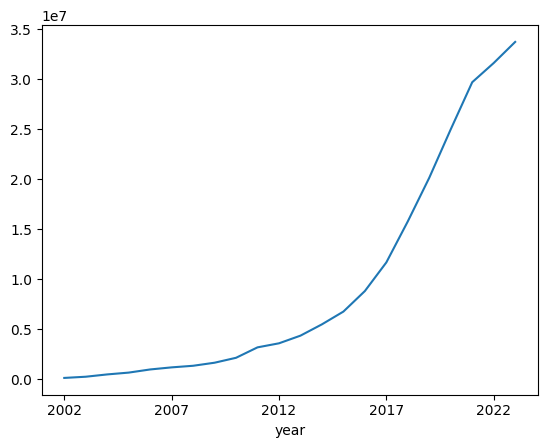

In [137]:
revenues.Revenues.plot()